In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from utils import preprocessing, transforms
from utils.constants import PLOTCOLORS
import matplotlib.pyplot as plt

RANDOM_STATE = 21

cwd = Path.cwd()
husky_data = cwd / "norlab-data"
vulpi_data = cwd / "data"
figs_path = cwd / "analysis" / "figs"
figs_path.mkdir(parents=True, exist_ok=True)

COLORS = {
    "base": PLOTCOLORS["dirt road"],
    "ours": PLOTCOLORS["concrete"],
}

In [2]:
# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

In [3]:
husky_summ = summary.copy()
vulpi_summ = summary.copy()

husky_dfs = preprocessing.get_recordings(husky_data, husky_summ)
vulpi_dfs = preprocessing.get_recordings(vulpi_data, vulpi_summ)

husky_pro = husky_dfs["pro"].copy()
vulpi_pro = vulpi_dfs["pro"].copy()

In [4]:
husky_pro["vx"], husky_pro["wz"] = transforms.unicycle_model(husky_pro)
vulpi_pro["vx"], vulpi_pro["wz"] = transforms.unicycle_model(vulpi_pro)

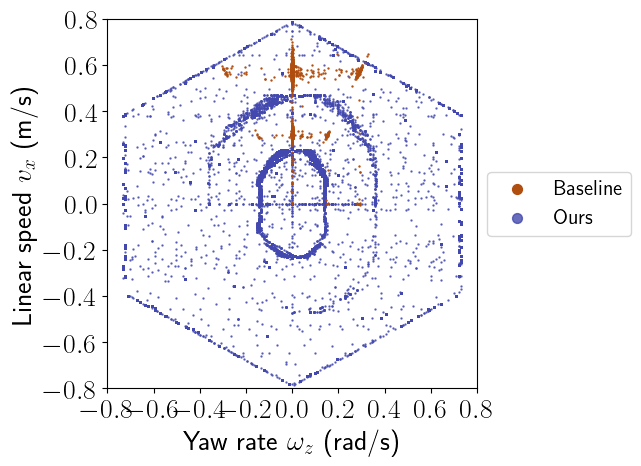

In [5]:
with plt.style.context('analysis/figure.mplstyle'):
    fig, ax = plt.subplots()
    ax.scatter(
        vulpi_pro.wz,
        vulpi_pro.vx,
        c=COLORS["base"],
        s=0.5,
        alpha=1,
        label="Baseline",
        zorder=5,
    )
    ax.scatter(
        husky_pro.wz,
        husky_pro.vx,
        c=COLORS["ours"],
        s=0.5,
        alpha=0.8,
        label="Ours",
        zorder=-1,
    )

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=10)

    ax.set_xlabel("Yaw rate $\omega_z$ (rad/s)")
    ax.set_ylabel("Linear speed $v_x$ (m/s)")

    ax.set_aspect("equal")
    ax.set_xlim((-0.8, 0.8))
    ax.set_ylim((-0.8, 0.8))
    # ax.set_xlim((-0.05, 0.8))
    # ax.set_ylim((-0.05, 0.8))

    fig.savefig(figs_path / "speeds.pdf", bbox_inches="tight")

In [6]:
from scipy import stats

descriptions = {
    "hvx": stats.describe(husky_pro.vx)._asdict(),
    "hwz": stats.describe(husky_pro.wz)._asdict(),
    "vvx": stats.describe(vulpi_pro.vx)._asdict(),
    "vwz": stats.describe(vulpi_pro.wz)._asdict(),
}
pd.DataFrame.from_dict(descriptions, orient="index")

,nobs,minmax,mean,variance,skewness,kurtosis
hvx,46663,"(-0.7834645669291338, 0.7874015748031497)",0.154932,0.073985,-0.280589,1.334197
hwz,46663,"(-0.730136005726557, 0.730136005726557)",0.025133,0.064045,-0.056890,2.333023
vvx,12320,"(-0.0035670115739818015, 0.7109512957192385)",0.497843,0.014909,-1.093982,-0.496962
vwz,12320,"(-0.30563893945385945, 0.32964410805526384)",0.003702,0.001291,5.108064,53.535356


In [7]:
with plt.style.context('./analysis/figure.mplstyle'):
    fig, axs = plt.subplots(ncols=2)
    vcols = [COLORS["base"], COLORS["ours"]]
    v_vx = axs[0].violinplot([vulpi_pro.vx, husky_pro.vx], showmeans=False)
    v_wz = axs[1].violinplot([vulpi_pro.wz, husky_pro.wz], showmeans=False)

    for pc_vx, pc_wz, col in zip(v_vx["bodies"], v_wz["bodies"], vcols):
        pc_vx.set_facecolor(col)
        pc_wz.set_facecolor(col)
        pc_vx.set_edgecolor(col)
        pc_wz.set_edgecolor(col)
        pc_vx.set_alpha(1)
        pc_wz.set_alpha(1)

    axs[0].set_xticks([1, 2], ["Baseline", "Ours"])
    axs[1].set_xticks([1, 2], ["Baseline", "Ours"])
    axs[0].set_ylim((-0.9, 0.9))
    axs[1].set_ylim((-0.9, 0.9))

    axs[0].set_ylabel("Linear speed $v_x$ (m/s)")
    axs[1].set_ylabel("Yaw rate $\omega_z$ (rad/s)")

    fig.tight_layout()

In [8]:

with plt.style.context('./analysis/figure.mplstyle'):
    fig = plt.figure(figsize=(9,17))
    subfigs = fig.subfigures(nrows=2)

    ax = subfigs[0].subplots()
    ax.scatter(
        vulpi_pro.wz,
        vulpi_pro.vx,
        c=COLORS["base"],
        s=0.5,
        alpha=1,
        label="Baseline",
        zorder=5,
    )
    ax.scatter(
        husky_pro.wz,
        husky_pro.vx,
        c=COLORS["ours"],
        s=0.5,
        alpha=0.8,
        label="Ours",
        zorder=-1,
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=10)
    ax.set_xlabel("Yaw rate $\omega_z$ (rad/s)")
    ax.set_ylabel("Linear speed $v_x$ (m/s)")
    ax.set_aspect("equal")
    ax.set_xlim((-0.8, 0.8))
    ax.set_ylim((-0.8, 0.8))

    axs = subfigs[1].subplots(ncols=2, width_ratios=[1, 1])
    vcols = [COLORS["base"], COLORS["ours"]]
    v_vx = axs[0].violinplot([vulpi_pro.vx, husky_pro.vx], showmeans=False)
    v_wz = axs[1].violinplot([vulpi_pro.wz, husky_pro.wz], showmeans=False)

    for pc_vx, pc_wz, col in zip(v_vx["bodies"], v_wz["bodies"], vcols):
        pc_vx.set_facecolor(col)
        pc_wz.set_facecolor(col)
        pc_vx.set_edgecolor(col)
        pc_wz.set_edgecolor(col)
        pc_vx.set_alpha(1)
        pc_wz.set_alpha(1)

    axs[0].set_xticks([1, 2], ["Baseline", "Ours"])
    axs[1].set_xticks([1, 2], ["Baseline", "Ours"])
    axs[0].set_ylim((-0.9, 0.9))
    axs[1].set_ylim((-0.9, 0.9))

    axs[0].set_ylabel("Linear speed $v_x$ (m/s)")
    axs[1].set_ylabel("Yaw rate $\omega_z$ (rad/s)")

fig.tight_layout()


# Rotationnality

In [9]:
from utils.constants import HuskyConstants

Bs = HuskyConstants.ugv_Bs
husky_pro["rho"] = (
    Bs * husky_pro.wz.abs() / (husky_pro.vx.abs() + Bs * husky_pro.wz.abs())
)
vulpi_pro["rho"] = (
    Bs * vulpi_pro.wz.abs() / (vulpi_pro.vx.abs() + Bs * vulpi_pro.wz.abs())
)

fig, ax = plt.subplots()
ax.hist(
    [vulpi_pro.rho, husky_pro.rho],
    label=["Baseline", "Ours"],
    color=[COLORS["base"], COLORS["ours"]],
    log=True,
)
ax.legend()
ax.set_xlabel("Rotationnality $\\rho$")
ax.set_ylabel("Counts")

Text(0, 0.5, 'Counts')

In [11]:
rho_desc = {
    "hrho": stats.describe(husky_pro.rho.dropna())._asdict(),
    "vrho": stats.describe(vulpi_pro.rho.dropna())._asdict(),
}
pd.DataFrame.from_dict(rho_desc, orient="index")

,nobs,minmax,mean,variance,skewness,kurtosis
hrho,46018,"(0.0, 1.0)",0.417131,0.159803,0.404527,-1.470874
vrho,12319,"(0.0, 1.0)",0.010497,0.003549,9.200214,108.633023
